In [1]:
import pandas as pd
import numpy as np
import json
import re 
import sys
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy.sparse import vstack

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util

import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline


In [3]:
#If you're not familiar with this, save it! Makes using jupyter notebook on laptops much easier
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
#another useful command to make data exploration easier
# NOTE: if you are using a massive dataset, this could slow down your code. 
pd.set_option('display.max_columns', None)

In [5]:
spotify_df = pd.read_csv('tracks.csv')
artists_df = pd.read_csv('artists.csv')

## Data Preparation

In [6]:
spotify_df.head()

id                                 name  popularity  \
0  35iwgR4jXetI318WEWsa1Q                                Carve           6   
1  021ht4sdgPcrDgSk7JTbKY  Capítulo 2.16 - Banquero Anarquista           0   
2  07A5yehtSnoedViJAZkNnc   Vivo para Quererte - Remasterizado           0   
3  08FmqUhxtyLTn6pAh6bk45        El Prisionero - Remasterizado           0   
4  08y9GfoqCWfOGsKdwojr5e                  Lady of the Evening           0   

   duration_ms  explicit              artists                  id_artists  \
0       126903         0              ['Uli']  ['45tIt06XoI0Iio4LBEVpls']   
1        98200         0  ['Fernando Pessoa']  ['14jtPCOoNZwquk5wd9DxrY']   
2       181640         0  ['Ignacio Corsini']  ['5LiOoJbxVSAMkBS2fUm3X2']   
3       176907         0  ['Ignacio Corsini']  ['5LiOoJbxVSAMkBS2fUm3X2']   
4       163080         0      ['Dick Haymes']  ['3BiJGZsyX9sJchTqcSA7Su']   

  release_date  danceability  energy  key  loudness  mode  speechiness  \
0   1922-02-22         0.645  0.4450    0   -13.338     1       0.4510   
1   1922-06-01         0.695  0.2630    0   -22.136     1       0.9570   
2   1922-03-21         0.434  0.1770    1   -21.180     1       0.0512   
3   1922-03-21         0.321  0.0946    7   -27.961     1       0.0504   
4         1922         0.402  0.1580    3   -16.900     0       0.0390   

   acousticness  instrumentalness  liveness  valence    tempo  time_signature  
0         0.674            0.7440     0.151    0.127  104.851               3  
1         0.797            0.0000     0.148    0.655  102.009               1  
2         0.994            0.0218     0.212    0.457  130.418               5  
3         0.995            0.9180     0.104    0.397  169.980               3  
4         0.989            0.1300     0.311    0.196  103.220               4

In [7]:
artists_df.head()

id  followers genres  \
0  0DheY5irMjBUeLybbCUEZ2        0.0     []   
1  0DlhY15l3wsrnlfGio2bjU        5.0     []   
2  0DmRESX2JknGPQyO15yxg7        0.0     []   
3  0DmhnbHjm1qw6NCYPeZNgJ        0.0     []   
4  0Dn11fWM7vHQ3rinvWEl4E        2.0     []   

                                             name  popularity  
0  Armid & Amir Zare Pashai feat. Sara Rouzbehani           0  
1                                     ปูนา ภาวิณี           0  
2                                           Sadaa           0  
3                                       Tra'gruda           0  
4                          Ioannis Panoutsopoulos           0

In [8]:
spotify_df.dtypes

id                   object
name                 object
popularity            int64
duration_ms           int64
explicit              int64
artists              object
id_artists           object
release_date         object
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
dtype: object

In [9]:
artists_df.dtypes

id             object
followers     float64
genres         object
name           object
popularity      int64
dtype: object

In [10]:
artists_df['genres'].values[0]


'[]'

In [11]:
artists_df['genres'].values[0][0]


'['

In [12]:
artists_df['genres_upd'] = artists_df['genres'].apply(lambda x: [re.sub(' ','_',i) for i in re.findall(r"'([^']*)'", x)])

In [13]:
spotify_df['artists_upd_v1'] = spotify_df['artists'].apply(lambda x: re.findall(r"'([^']*)'", x))

In [14]:
spotify_df['artists'].values[0]


"['Uli']"

In [15]:
spotify_df['artists_upd_v1'].values[0][0]


'Uli'

In [16]:
spotify_df[spotify_df['artists_upd_v1'].apply(lambda x: not x)].head(5)


id                     name  popularity  duration_ms  \
164  1xEEYhWxT4WhDQdxfPCT8D                Snake Rag          20       194533   
170  3rauXVLOOM5BlxWqUcDpkg             Chimes Blues          14       170827   
172  1UdqHVRFYMZKU2Q7xkLtYc     Pickin' On Your Baby          11       197493   
174  0Vl2DO5U6FjgBpzCtBN3OA  Everybody Loves My Baby          10       152507   
180  5SvyP1ZeJX1jA7AOZD08NA                    Tears          10       187227   

     explicit                             artists                  id_artists  \
164         0  ["King Oliver's Creole Jazz Band"]  ['08Zk65toyJllap1MnzljxZ']   
170         0  ["King Oliver's Creole Jazz Band"]  ['08Zk65toyJllap1MnzljxZ']   
172         0    ["Clarence Williams' Blue Five"]  ['6RuQvIr0t0otZHnAxXTGkm']   
174         0    ["Clarence Williams' Blue Five"]  ['6RuQvIr0t0otZHnAxXTGkm']   
180         0  ["King Oliver's Creole Jazz Band"]  ['08Zk65toyJllap1MnzljxZ']   

    release_date  danceability  energy  key  loudness  mode  speechiness  \
164         1923         0.708   0.361    0   -11.764     0       0.0441   
170         1923         0.546   0.189    0   -15.984     1       0.0581   
172         1923         0.520   0.153    0   -14.042     1       0.0440   
174         1923         0.514   0.193    2   -13.920     0       0.2380   
180         1923         0.359   0.357    3   -11.810     1       0.0511   

     acousticness  instrumentalness  liveness  valence    tempo  \
164         0.994             0.883     0.103    0.902  105.695   
170         0.996             0.908     0.339    0.554   80.318   
172         0.995             0.131     0.353    0.319  102.937   
174         0.996             0.199     0.248    0.665  180.674   
180         0.994             0.819     0.290    0.753  205.053   

     time_signature artists_upd_v1  
164               4             []  
170               4             []  
172               4             []  
174               4             []  
180               4             []

In [17]:
spotify_df['artists_upd_v2'] = spotify_df['artists'].apply(lambda x: re.findall('\"(.*?)\"',x))
spotify_df['artists_upd'] = np.where(spotify_df['artists_upd_v1'].apply(lambda x: not x), spotify_df['artists_upd_v2'], spotify_df['artists_upd_v1'] )

In [18]:
spotify_df[spotify_df['artists_upd_v1'].apply(lambda x: not x)].head(5)


id                     name  popularity  duration_ms  \
164  1xEEYhWxT4WhDQdxfPCT8D                Snake Rag          20       194533   
170  3rauXVLOOM5BlxWqUcDpkg             Chimes Blues          14       170827   
172  1UdqHVRFYMZKU2Q7xkLtYc     Pickin' On Your Baby          11       197493   
174  0Vl2DO5U6FjgBpzCtBN3OA  Everybody Loves My Baby          10       152507   
180  5SvyP1ZeJX1jA7AOZD08NA                    Tears          10       187227   

     explicit                             artists                  id_artists  \
164         0  ["King Oliver's Creole Jazz Band"]  ['08Zk65toyJllap1MnzljxZ']   
170         0  ["King Oliver's Creole Jazz Band"]  ['08Zk65toyJllap1MnzljxZ']   
172         0    ["Clarence Williams' Blue Five"]  ['6RuQvIr0t0otZHnAxXTGkm']   
174         0    ["Clarence Williams' Blue Five"]  ['6RuQvIr0t0otZHnAxXTGkm']   
180         0  ["King Oliver's Creole Jazz Band"]  ['08Zk65toyJllap1MnzljxZ']   

    release_date  danceability  energy  key  loudness  mode  speechiness  \
164         1923         0.708   0.361    0   -11.764     0       0.0441   
170         1923         0.546   0.189    0   -15.984     1       0.0581   
172         1923         0.520   0.153    0   -14.042     1       0.0440   
174         1923         0.514   0.193    2   -13.920     0       0.2380   
180         1923         0.359   0.357    3   -11.810     1       0.0511   

     acousticness  instrumentalness  liveness  valence    tempo  \
164         0.994             0.883     0.103    0.902  105.695   
170         0.996             0.908     0.339    0.554   80.318   
172         0.995             0.131     0.353    0.319  102.937   
174         0.996             0.199     0.248    0.665  180.674   
180         0.994             0.819     0.290    0.753  205.053   

     time_signature artists_upd_v1                    artists_upd_v2  \
164               4             []  [King Oliver's Creole Jazz Band]   
170               4             []  [King Oliver's Creole Jazz Band]   
172               4             []    [Clarence Williams' Blue Five]   
174               4             []    [Clarence Williams' Blue Five]   
180               4             []  [King Oliver's Creole Jazz Band]   

                          artists_upd  
164  [King Oliver's Creole Jazz Band]  
170  [King Oliver's Creole Jazz Band]  
172    [Clarence Williams' Blue Five]  
174    [Clarence Williams' Blue Five]  
180  [King Oliver's Creole Jazz Band]

In [19]:
spotify_df['artists_song'] = spotify_df.apply(
    lambda row: str(row['artists_upd'][0]) + str(row['name']), 
    axis=1
)

In [20]:
spotify_df.sort_values(['artists_song','release_date'], ascending = False, inplace = True)


In [21]:
spotify_df[spotify_df['name']=='Adore You']


id       name  popularity  duration_ms  explicit  \
86217  5AnCLGg35ziFOloEnXK4uu  Adore You          71       278747         0   
91884  3jjujdWJ72nww5eGnfs2E7  Adore You          88       207133         0   
92524  1M4qEo4HE3PRaCOM7EXNJq  Adore You          74       207133         0   

                artists                  id_artists release_date  \
86217   ['Miley Cyrus']  ['5YGY8feqx7naU7z4HrwZM6']   2013-10-04   
91884  ['Harry Styles']  ['6KImCVD70vtIoJWnq6nGn3']   2019-12-13   
92524  ['Harry Styles']  ['6KImCVD70vtIoJWnq6nGn3']   2019-12-06   

       danceability  energy  key  loudness  mode  speechiness  acousticness  \
86217         0.583   0.655    0    -5.407     1       0.0315        0.1110   
91884         0.676   0.771    8    -3.675     1       0.0483        0.0237   
92524         0.676   0.771    8    -3.675     1       0.0483        0.0237   

       instrumentalness  liveness  valence    tempo  time_signature  \
86217          0.000004     0.113    0.201  119.759               4   
91884          0.000007     0.102    0.569   99.048               4   
92524          0.000007     0.102    0.569   99.048               4   

       artists_upd_v1 artists_upd_v2     artists_upd           artists_song  
86217   [Miley Cyrus]             []   [Miley Cyrus]   Miley CyrusAdore You  
91884  [Harry Styles]             []  [Harry Styles]  Harry StylesAdore You  
92524  [Harry Styles]             []  [Harry Styles]  Harry StylesAdore You

In [22]:
print(len(spotify_df))
spotify_df.drop_duplicates('artists_song',inplace = True)
print(len(spotify_df))

586672
523475


In [23]:
spotify_df[spotify_df['name']=='Adore You']


id       name  popularity  duration_ms  explicit  \
86217  5AnCLGg35ziFOloEnXK4uu  Adore You          71       278747         0   
91884  3jjujdWJ72nww5eGnfs2E7  Adore You          88       207133         0   

                artists                  id_artists release_date  \
86217   ['Miley Cyrus']  ['5YGY8feqx7naU7z4HrwZM6']   2013-10-04   
91884  ['Harry Styles']  ['6KImCVD70vtIoJWnq6nGn3']   2019-12-13   

       danceability  energy  key  loudness  mode  speechiness  acousticness  \
86217         0.583   0.655    0    -5.407     1       0.0315        0.1110   
91884         0.676   0.771    8    -3.675     1       0.0483        0.0237   

       instrumentalness  liveness  valence    tempo  time_signature  \
86217          0.000004     0.113    0.201  119.759               4   
91884          0.000007     0.102    0.569   99.048               4   

       artists_upd_v1 artists_upd_v2     artists_upd           artists_song  
86217   [Miley Cyrus]             []   [Miley Cyrus]   Miley CyrusAdore You  
91884  [Harry Styles]             []  [Harry Styles]  Harry StylesAdore You

In [24]:
artists_exploded = spotify_df[['artists_upd','id']].explode('artists_upd')
print(len(artists_exploded))

674010


In [25]:
artists_exploded.head()

artists_upd                      id
538433         최진희  3u1C6nWVRoP5F0w8gGrDL3
404349          지수  1Mv4u308L16NZDZiD6HZCy
210091          지선  1jvoY322nxyKXq8OBhgmSY
270610         조정현  2ghebdwe2pNXT4eL34T7pW
208974         장정우  7rxpWwcXNgDUXl0wN0gUvp

In [26]:
artists_df.head()

id  followers genres  \
0  0DheY5irMjBUeLybbCUEZ2        0.0     []   
1  0DlhY15l3wsrnlfGio2bjU        5.0     []   
2  0DmRESX2JknGPQyO15yxg7        0.0     []   
3  0DmhnbHjm1qw6NCYPeZNgJ        0.0     []   
4  0Dn11fWM7vHQ3rinvWEl4E        2.0     []   

                                             name  popularity genres_upd  
0  Armid & Amir Zare Pashai feat. Sara Rouzbehani           0         []  
1                                     ปูนา ภาวิณี           0         []  
2                                           Sadaa           0         []  
3                                       Tra'gruda           0         []  
4                          Ioannis Panoutsopoulos           0         []

In [27]:
spotify_df.head()

id                name  popularity  duration_ms  \
538433  3u1C6nWVRoP5F0w8gGrDL3              사랑의 미로          25       222380   
404349  1Mv4u308L16NZDZiD6HZCy            사랑은 힘든가봐          28       213440   
210091  1jvoY322nxyKXq8OBhgmSY                어떡하죠          44       244360   
270610  2ghebdwe2pNXT4eL34T7pW          그아픔까지사랑한거야          32       237688   
208974  7rxpWwcXNgDUXl0wN0gUvp  천국의 기억 장정우 Version          31       280372   

        explicit  artists                  id_artists release_date  \
538433         0  ['최진희']  ['1NSrAf8XJYJVgAXKoxaMet']   1987-06-01   
404349         0   ['지수']  ['4c9QIMfEbIIynuaswyxGx9']   2005-12-23   
210091         0   ['지선']  ['2Mo9NQaNCFCWSR5CnlfmbN']   2011-10-13   
270610         0  ['조정현']  ['2WTpsPucygbYRnCnoEUkJQ']   1989-06-15   
208974         0  ['장정우']  ['5L7zKs2ftwENWOMI7LFaN1']   2003-12-24   

        danceability  energy  key  loudness  mode  speechiness  acousticness  \
538433         0.367   0.194    7   -19.057     1       0.0400         0.617   
404349         0.675   0.785    4    -5.026     0       0.0280         0.379   
210091         0.606   0.341    0    -7.094     1       0.0513         0.779   
270610         0.447   0.215   10   -16.478     1       0.0272         0.568   
208974         0.494   0.656    7    -6.347     0       0.0262         0.659   

        instrumentalness  liveness  valence    tempo  time_signature  \
538433          0.000006    0.1620    0.367  144.316               4   
404349          0.000000    0.3530    0.623  103.008               4   
210091          0.000000    0.1440    0.294  135.667               4   
270610          0.000001    0.0649    0.177   71.979               4   
208974          0.000007    0.1110    0.420   82.003               4   

       artists_upd_v1 artists_upd_v2 artists_upd           artists_song  
538433          [최진희]             []       [최진희]              최진희사랑의 미로  
404349           [지수]             []        [지수]             지수사랑은 힘든가봐  
210091           [지선]             []        [지선]                 지선어떡하죠  
270610          [조정현]             []       [조정현]          조정현그아픔까지사랑한거야  
208974          [장정우]             []       [장정우]  장정우천국의 기억 장정우 Version

In [28]:
artists_exploded.rename(columns = {'id':'song_id'}, inplace = True)

In [29]:
artists_df.rename(columns = {'id':'artist_id', 'name':'artist_name'}, inplace = True)

In [30]:
spotify_df.rename(columns = {'id':'song_id', 'name':'song_name'}, inplace = True)

In [31]:
artists_exploded_enriched = artists_exploded.merge(artists_df, how = 'left', left_on = 'artists_upd',right_on = 'artist_name')

In [32]:
artists_exploded_enriched.head()

artists_upd                 song_id               artist_id  followers  \
0         최진희  3u1C6nWVRoP5F0w8gGrDL3  1NSrAf8XJYJVgAXKoxaMet      788.0   
1          지수  1Mv4u308L16NZDZiD6HZCy                     NaN        NaN   
2          지선  1jvoY322nxyKXq8OBhgmSY  2Mo9NQaNCFCWSR5CnlfmbN      262.0   
3         조정현  2ghebdwe2pNXT4eL34T7pW                     NaN        NaN   
4         장정우  7rxpWwcXNgDUXl0wN0gUvp  5L7zKs2ftwENWOMI7LFaN1       11.0   

     genres artist_name  popularity genres_upd  
0  ['trot']         최진희        17.0     [trot]  
1       NaN         NaN         NaN        NaN  
2        []          지선        37.0         []  
3       NaN         NaN         NaN        NaN  
4        []         장정우        23.0         []

In [33]:
len(artists_exploded_enriched)

763195

In [34]:
artists_exploded_enriched_nonnull = artists_exploded_enriched[~artists_exploded_enriched.genres_upd.isnull()]

In [35]:
len(artists_exploded_enriched_nonnull)

739616

In [36]:
artists_exploded_enriched_nonnull[artists_exploded_enriched_nonnull['song_id'].duplicated(keep=False)]

artists_upd  \
32                                                    龍正翔   
33                                                     鳳霞   
36                                                    龍正翔   
37                                                     鳳霞   
70                                                  黑澀會美眉   
...                                                   ...   
763035  "Jesus Christ Superstar" Apostles - Original S...   
763036                                        Murray Head   
763037                                         Ian Gillan   
763038                                Andrew Lloyd Webber   
763039                                           Tim Rice   

                       song_id               artist_id  followers  \
32      1bIvgMYAy1Iv9y6INBiYZK  3fMe46R2xDDUppVGCPeuD8        0.0   
33      1bIvgMYAy1Iv9y6INBiYZK  0f47VXNYZL53LxvU6zlAxF        0.0   
36      3wVnTrkV3cCw7HKkSLAm3s  3fMe46R2xDDUppVGCPeuD8        0.0   
37      3wVnTrkV3cCw7HKkSLAm3s  0f47VXNYZL53LxvU6zlAxF        0.0   
70      2rJ2eeS34mWA3p9EKroqWI  6RjFDA4deaWUnbFmgJ0Gak       29.0   
...                        ...                     ...        ...   
763035  5UbK7BJAIhkUIYYLUABLdN  1T1Hnf7jWiJPFUTi6voWwU      126.0   
763036  5UbK7BJAIhkUIYYLUABLdN  479Yp6DvyXoIaCssAxB4QR    25479.0   
763037  5UbK7BJAIhkUIYYLUABLdN  4QCflfSOonkybNw5D7GqGk    35280.0   
763038  5UbK7BJAIhkUIYYLUABLdN  4aP1lp10BRYZO658B2NwkG   213327.0   
763039  5UbK7BJAIhkUIYYLUABLdN  3KDpcZPHxvsaVk5PReoGqh     1553.0   

                                        genres  \
32                                          []   
33                                          []   
36                                          []   
37                                          []   
70                                          []   
...                                        ...   
763035                                      []   
763036                        ['new wave pop']   
763037                           ['hard rock']   
763038  ['broadway', 'show tunes', 'west end']   
763039                                      []   

                                              artist_name  popularity  \
32                                                    龍正翔        22.0   
33                                                     鳳霞        23.0   
36                                                    龍正翔        22.0   
37                                                     鳳霞        23.0   
70                                                  黑澀會美眉        28.0   
...                                                   ...         ...   
763035  "Jesus Christ Superstar" Apostles - Original S...        36.0   
763036                                        Murray Head        55.0   
763037                                         Ian Gillan        45.0   
763038                                Andrew Lloyd Webber        67.0   
763039                                           Tim Rice        51.0   

                              genres_upd  
32                                    []  
33                                    []  
36                                    []  
37                                    []  
70                                    []  
...                                  ...  
763035                                []  
763036                    [new_wave_pop]  
763037                       [hard_rock]  
763038  [broadway, show_tunes, west_end]  
763039                                []  

[347326 rows x 8 columns]

In [37]:
artists_exploded_enriched_nonnull[artists_exploded_enriched_nonnull['song_id'] =='5UbK7BJAIhkUIYYLUABLdN']

artists_upd  \
763035  "Jesus Christ Superstar" Apostles - Original S...   
763036                                        Murray Head   
763037                                         Ian Gillan   
763038                                Andrew Lloyd Webber   
763039                                           Tim Rice   

                       song_id               artist_id  followers  \
763035  5UbK7BJAIhkUIYYLUABLdN  1T1Hnf7jWiJPFUTi6voWwU      126.0   
763036  5UbK7BJAIhkUIYYLUABLdN  479Yp6DvyXoIaCssAxB4QR    25479.0   
763037  5UbK7BJAIhkUIYYLUABLdN  4QCflfSOonkybNw5D7GqGk    35280.0   
763038  5UbK7BJAIhkUIYYLUABLdN  4aP1lp10BRYZO658B2NwkG   213327.0   
763039  5UbK7BJAIhkUIYYLUABLdN  3KDpcZPHxvsaVk5PReoGqh     1553.0   

                                        genres  \
763035                                      []   
763036                        ['new wave pop']   
763037                           ['hard rock']   
763038  ['broadway', 'show tunes', 'west end']   
763039                                      []   

                                              artist_name  popularity  \
763035  "Jesus Christ Superstar" Apostles - Original S...        36.0   
763036                                        Murray Head        55.0   
763037                                         Ian Gillan        45.0   
763038                                Andrew Lloyd Webber        67.0   
763039                                           Tim Rice        51.0   

                              genres_upd  
763035                                []  
763036                    [new_wave_pop]  
763037                       [hard_rock]  
763038  [broadway, show_tunes, west_end]  
763039                                []

In [38]:
artists_genres_consolidated = artists_exploded_enriched_nonnull.groupby('song_id')['genres_upd'].apply(list).reset_index()


In [39]:
artists_genres_consolidated['consolidates_genre_lists'] = artists_genres_consolidated['genres_upd'].apply(lambda x: list(set(list(itertools.chain.from_iterable(x)))))


In [40]:
artists_genres_consolidated.head()

song_id                                         genres_upd  \
0  0004Uy71ku11n3LMpuyf59                                    [[polish_rock]]   
1  000CSYu4rvd8cQ7JilfxhZ              [[country_quebecois, rock_quebecois]]   
2  000DsoWJKHdaUmhgcnpr8j                                      [[barnmusik]]   
3  000G1xMMuwxNHmwVsBdtj1  [[candy_pop, new_wave, new_wave_pop, permanent...   
4  000KblXP5csWFFFsD6smOy  [[chamame, folclore_salteno, folklore_argentino]]   

                            consolidates_genre_lists  
0                                      [polish_rock]  
1                [country_quebecois, rock_quebecois]  
2                                        [barnmusik]  
3  [new_wave_pop, power_pop, rock, candy_pop, new...  
4    [folclore_salteno, chamame, folklore_argentino]

In [41]:
spotify_df_upd = spotify_df.merge(artists_genres_consolidated[['song_id','consolidates_genre_lists']], on = 'song_id',how = 'left')


In [42]:
spotify_df_upd.head()

song_id           song_name  popularity  duration_ms  \
0  3u1C6nWVRoP5F0w8gGrDL3              사랑의 미로          25       222380   
1  1Mv4u308L16NZDZiD6HZCy            사랑은 힘든가봐          28       213440   
2  1jvoY322nxyKXq8OBhgmSY                어떡하죠          44       244360   
3  2ghebdwe2pNXT4eL34T7pW          그아픔까지사랑한거야          32       237688   
4  7rxpWwcXNgDUXl0wN0gUvp  천국의 기억 장정우 Version          31       280372   

   explicit  artists                  id_artists release_date  danceability  \
0         0  ['최진희']  ['1NSrAf8XJYJVgAXKoxaMet']   1987-06-01         0.367   
1         0   ['지수']  ['4c9QIMfEbIIynuaswyxGx9']   2005-12-23         0.675   
2         0   ['지선']  ['2Mo9NQaNCFCWSR5CnlfmbN']   2011-10-13         0.606   
3         0  ['조정현']  ['2WTpsPucygbYRnCnoEUkJQ']   1989-06-15         0.447   
4         0  ['장정우']  ['5L7zKs2ftwENWOMI7LFaN1']   2003-12-24         0.494   

   energy  key  loudness  mode  speechiness  acousticness  instrumentalness  \
0   0.194    7   -19.057     1       0.0400         0.617          0.000006   
1   0.785    4    -5.026     0       0.0280         0.379          0.000000   
2   0.341    0    -7.094     1       0.0513         0.779          0.000000   
3   0.215   10   -16.478     1       0.0272         0.568          0.000001   
4   0.656    7    -6.347     0       0.0262         0.659          0.000007   

   liveness  valence    tempo  time_signature artists_upd_v1 artists_upd_v2  \
0    0.1620    0.367  144.316               4          [최진희]             []   
1    0.3530    0.623  103.008               4           [지수]             []   
2    0.1440    0.294  135.667               4           [지선]             []   
3    0.0649    0.177   71.979               4          [조정현]             []   
4    0.1110    0.420   82.003               4          [장정우]             []   

  artists_upd           artists_song consolidates_genre_lists  
0       [최진희]              최진희사랑의 미로                   [trot]  
1        [지수]             지수사랑은 힘든가봐                      NaN  
2        [지선]                 지선어떡하죠                       []  
3       [조정현]          조정현그아픔까지사랑한거야                      NaN  
4       [장정우]  장정우천국의 기억 장정우 Version                       []

In [43]:
len(spotify_df_upd)

523475

## Feature Engineering

In [44]:
spotify_df_upd.columns

Index(['song_id', 'song_name', 'popularity', 'duration_ms', 'explicit',
       'artists', 'id_artists', 'release_date', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'artists_upd_v1', 'artists_upd_v2', 'artists_upd', 'artists_song',
       'consolidates_genre_lists'],
      dtype='object')

In [45]:
spotify_df_upd['year'] = spotify_df_upd['release_date'].apply(lambda x: x.split('-')[0])

In [46]:
spotify_df_upd.dtypes

song_id                      object
song_name                    object
popularity                    int64
duration_ms                   int64
explicit                      int64
artists                      object
id_artists                   object
release_date                 object
danceability                float64
energy                      float64
key                           int64
loudness                    float64
mode                          int64
speechiness                 float64
acousticness                float64
instrumentalness            float64
liveness                    float64
valence                     float64
tempo                       float64
time_signature                int64
artists_upd_v1               object
artists_upd_v2               object
artists_upd                  object
artists_song                 object
consolidates_genre_lists     object
year                         object
dtype: object

In [47]:
float_cols = spotify_df_upd.dtypes[spotify_df_upd.dtypes == 'float64'].index.values

In [48]:
ohe_cols = 'popularity'

In [49]:
spotify_df_upd['popularity'].describe()


count    523475.000000
mean         27.235870
std          18.030233
min           0.000000
25%          13.000000
50%          27.000000
75%          40.000000
max          99.000000
Name: popularity, dtype: float64

In [50]:
# create 5 point buckets for popularity 
spotify_df_upd['popularity_red'] = spotify_df_upd['popularity'].apply(lambda x: int(x/5))

In [51]:
# tfidf can't handle nulls so fill any null values with an empty list
spotify_df_upd['consolidates_genre_lists'] = spotify_df_upd['consolidates_genre_lists'].apply(lambda d: d if isinstance(d, list) else [])

In [52]:
spotify_df_upd.head()

song_id           song_name  popularity  duration_ms  \
0  3u1C6nWVRoP5F0w8gGrDL3              사랑의 미로          25       222380   
1  1Mv4u308L16NZDZiD6HZCy            사랑은 힘든가봐          28       213440   
2  1jvoY322nxyKXq8OBhgmSY                어떡하죠          44       244360   
3  2ghebdwe2pNXT4eL34T7pW          그아픔까지사랑한거야          32       237688   
4  7rxpWwcXNgDUXl0wN0gUvp  천국의 기억 장정우 Version          31       280372   

   explicit  artists                  id_artists release_date  danceability  \
0         0  ['최진희']  ['1NSrAf8XJYJVgAXKoxaMet']   1987-06-01         0.367   
1         0   ['지수']  ['4c9QIMfEbIIynuaswyxGx9']   2005-12-23         0.675   
2         0   ['지선']  ['2Mo9NQaNCFCWSR5CnlfmbN']   2011-10-13         0.606   
3         0  ['조정현']  ['2WTpsPucygbYRnCnoEUkJQ']   1989-06-15         0.447   
4         0  ['장정우']  ['5L7zKs2ftwENWOMI7LFaN1']   2003-12-24         0.494   

   energy  key  loudness  mode  speechiness  acousticness  instrumentalness  \
0   0.194    7   -19.057     1       0.0400         0.617          0.000006   
1   0.785    4    -5.026     0       0.0280         0.379          0.000000   
2   0.341    0    -7.094     1       0.0513         0.779          0.000000   
3   0.215   10   -16.478     1       0.0272         0.568          0.000001   
4   0.656    7    -6.347     0       0.0262         0.659          0.000007   

   liveness  valence    tempo  time_signature artists_upd_v1 artists_upd_v2  \
0    0.1620    0.367  144.316               4          [최진희]             []   
1    0.3530    0.623  103.008               4           [지수]             []   
2    0.1440    0.294  135.667               4           [지선]             []   
3    0.0649    0.177   71.979               4          [조정현]             []   
4    0.1110    0.420   82.003               4          [장정우]             []   

  artists_upd           artists_song consolidates_genre_lists  year  \
0       [최진희]              최진희사랑의 미로                   [trot]  1987   
1        [지수]             지수사랑은 힘든가봐                       []  2005   
2        [지선]                 지선어떡하죠                       []  2011   
3       [조정현]          조정현그아픔까지사랑한거야                       []  1989   
4       [장정우]  장정우천국의 기억 장정우 Version                       []  2003   

   popularity_red  
0               5  
1               5  
2               8  
3               6  
4               6

In [53]:
#simple function to create OHE features
#this gets passed later on
def ohe_prep(df, column, new_name): 
    """ 
    Create One Hot Encoded features of a specific column

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        column (str): Column to be processed
        new_name (str): new column name to be used
        
    Returns: 
        tf_df: One hot encoded features 
    """
    
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df

In [54]:
def create_tfidf_features_in_chunks(df, chunk_size=10000):
    """
    Process the DataFrame in chunks to create TF-IDF features.

    Parameters:
        df (pandas DataFrame): Input DataFrame with 'consolidates_genre_lists' column.
        chunk_size (int): Number of rows to process in each chunk.

    Returns:
        genre_df (pandas DataFrame): The final TF-IDF feature set in a sparse format.
    """
    tfidf = TfidfVectorizer()
    tfidf_matrices = []

    # Fit the TF-IDF model on the entire column to learn the vocabulary
    tfidf.fit(df['consolidates_genre_lists'].apply(lambda x: " ".join(x)))

    # Process the DataFrame in chunks
    for start in range(0, len(df), chunk_size):
        end = min(start + chunk_size, len(df))
        chunk = df.iloc[start:end]

        # Transform the chunk using TF-IDF
        tfidf_matrix_chunk = tfidf.transform(chunk['consolidates_genre_lists'].apply(lambda x: " ".join(x)))
        tfidf_matrices.append(tfidf_matrix_chunk)

    # Combine all sparse matrices
    combined_tfidf_matrix = vstack(tfidf_matrices)

    # Convert the combined sparse matrix to a sparse DataFrame
    genre_df = pd.DataFrame.sparse.from_spmatrix(
        combined_tfidf_matrix,
        columns=['genre|' + i for i in tfidf.get_feature_names_out()]
    )

    return genre_df



In [55]:
def create_feature_set(df, float_cols, chunk_size=10000):
    """ 
    Process Spotify df to create a final set of features that will be used to generate recommendations.

    Parameters: 
        df (pandas DataFrame): Spotify DataFrame
        float_cols (list(str)): List of float columns that will be scaled
        chunk_size (int): Number of rows to process in each chunk
        
    Returns: 
        final (pandas DataFrame): Final set of features 
    """
    # Create TF-IDF features using incremental processing
    genre_df = create_tfidf_features_in_chunks(df, chunk_size=chunk_size)

    # One-hot encode the 'year' and 'popularity_red' columns
    year_ohe = ohe_prep(df, 'year', 'year') * 0.5
    popularity_ohe = ohe_prep(df, 'popularity_red', 'pop') * 0.15

    # Scale float columns
    floats = df[float_cols].reset_index(drop=True)
    scaler = MinMaxScaler()
    floats_scaled = pd.DataFrame(scaler.fit_transform(floats), columns=floats.columns) * 0.2

    # Concatenate all features
    final = pd.concat([genre_df, floats_scaled, popularity_ohe, year_ohe], axis=1)

    # Add song ID
    final['song_id'] = df['song_id'].values

    return final


In [56]:
complete_feature_set = create_feature_set(spotify_df_upd, float_cols=float_cols, chunk_size=10000)#.mean(axis = 0)


In [57]:
complete_feature_set.head()

genre|21st_century_classical  genre|432hz  genre|48g  genre|_brasileira  \
0                           0.0          0.0        0.0                0.0   
1                           0.0          0.0        0.0                0.0   
2                           0.0          0.0        0.0                0.0   
3                           0.0          0.0        0.0                0.0   
4                           0.0          0.0        0.0                0.0   

   genre|_hip_hop  genre|_house  genre|a3  genre|a_cappella  genre|abstract  \
0             0.0           0.0       0.0               0.0             0.0   
1             0.0           0.0       0.0               0.0             0.0   
2             0.0           0.0       0.0               0.0             0.0   
3             0.0           0.0       0.0               0.0             0.0   
4             0.0           0.0       0.0               0.0             0.0   

   genre|abstract_beats  genre|abstract_hip_hop  genre|abstract_idm  \
0                   0.0                     0.0                 0.0   
1                   0.0                     0.0                 0.0   
2                   0.0                     0.0                 0.0   
3                   0.0                     0.0                 0.0   
4                   0.0                     0.0                 0.0   

   genre|accordeon  genre|accordion  genre|acid_house  genre|acid_jazz  \
0              0.0              0.0               0.0              0.0   
1              0.0              0.0               0.0              0.0   
2              0.0              0.0               0.0              0.0   
3              0.0              0.0               0.0              0.0   
4              0.0              0.0               0.0              0.0   

   genre|acid_rock  genre|acid_techno  genre|acid_trance  genre|acidcore  \
0              0.0                0.0                0.0             0.0   
1              0.0                0.0                0.0             0.0   
2              0.0                0.0                0.0             0.0   
3              0.0                0.0                0.0             0.0   
4              0.0                0.0                0.0             0.0   

   genre|acousmatic  genre|acoustic  genre|acoustic_blues  \
0               0.0             0.0                   0.0   
1               0.0             0.0                   0.0   
2               0.0             0.0                   0.0   
3               0.0             0.0                   0.0   
4               0.0             0.0                   0.0   

   genre|acoustic_chill  genre|acoustic_guitar_cover  genre|acoustic_opm  \
0                   0.0                          0.0                 0.0   
1                   0.0                          0.0                 0.0   
2                   0.0                          0.0                 0.0   
3                   0.0                          0.0                 0.0   
4                   0.0                          0.0                 0.0   

   genre|acoustic_pop  genre|acoustic_punk  genre|acoustic_rock  \
0                 0.0                  0.0                  0.0   
1                 0.0                  0.0                  0.0   
2                 0.0                  0.0                  0.0   
3                 0.0                  0.0                  0.0   
4                 0.0                  0.0                  0.0   

   genre|action_rock  genre|adoracao  genre|adoracion  genre|adult_standards  \
0                0.0             0.0              0.0                    0.0   
1                0.0             0.0              0.0                    0.0   
2                0.0             0.0              0.0                    0.0   
3                0.0             0.0              0.0                    0.0   
4                0.0             0.0              0.0                    0.0   

   genre|adventista  g

In [58]:
complete_feature_set.columns

Index(['genre|21st_century_classical', 'genre|432hz', 'genre|48g',
       'genre|_brasileira', 'genre|_hip_hop', 'genre|_house', 'genre|a3',
       'genre|a_cappella', 'genre|abstract', 'genre|abstract_beats',
       ...
       'year|2013', 'year|2014', 'year|2015', 'year|2016', 'year|2017',
       'year|2018', 'year|2019', 'year|2020', 'year|2021', 'song_id'],
      dtype='object', length=4900)

In [59]:
len(complete_feature_set)

523475

## Connect to Spotify API

In [60]:
#client id and secret for my application
client_id = 'd1486c9b4887425491c11b2d950b2787'
client_secret= '9876489640b54672adf8b48e7e082239'

In [61]:
scope = 'user-library-read'

if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: %s username" % (sys.argv[0],))
    sys.exit()

In [62]:
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [63]:
token = util.prompt_for_user_token(scope, client_id= client_id, client_secret=client_secret, redirect_uri='http://google.com/')


In [64]:
sp = spotipy.Spotify(auth=token)

In [65]:
#gather playlist names and images. 
#images aren't going to be used until I start building a UI
id_name = {}
list_photo = {}
for i in sp.current_user_playlists()['items']:

    id_name[i['name']] = i['uri'].split(':')[2]
    list_photo[i['uri'].split(':')[2]] = i['images'][0]['url']

In [66]:
id_name

{'Telugu': '5JxQ1pD80jH50DmV82J7sp',
 'Kannada': '1fnierv3T3KwL322VggpU9',
 'English': '64iZYJhuzzHP2FAZRV1M4S',
 'Indie': '1Ws5jxIHsLflGQlMrTsxwP',
 'Bollywood': '0r199YKuo0nxv7f82Icrub'}

In [67]:
def create_necessary_outputs(playlist_name,id_dic, df):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        playlist_name (str): name of the playlist you'd like to pull from the spotify API
        id_dic (dic): dictionary that maps playlist_name to playlist_id
        df (pandas dataframe): spotify datafram
        
    Returns: 
        playlist: all songs in the playlist THAT ARE AVAILABLE IN THE KAGGLE DATASET
    """
    
    #generate playlist dataframe
    playlist = pd.DataFrame()
    playlist_name = playlist_name

    for ix, i in enumerate(sp.playlist(id_dic[playlist_name])['tracks']['items']):
        #print(i['track']['artists'][0]['name'])
        playlist.loc[ix, 'artist'] = i['track']['artists'][0]['name']
        playlist.loc[ix, 'name'] = i['track']['name']
        playlist.loc[ix, 'id'] = i['track']['id'] # ['uri'].split(':')[2]
        playlist.loc[ix, 'url'] = i['track']['album']['images'][1]['url']
        playlist.loc[ix, 'date_added'] = i['added_at']

    playlist['date_added'] = pd.to_datetime(playlist['date_added'])  
    
    playlist = playlist[playlist['id'].isin(df['song_id'].values)].sort_values('date_added',ascending = False)
    
    return playlist

In [68]:
playlist_English = create_necessary_outputs('English', id_name,spotify_df_upd)
playlist_Telugu = create_necessary_outputs('Telugu', id_name,spotify_df_upd)
playlist_Kannada = create_necessary_outputs('Kannada', id_name,spotify_df_upd)
playlist_Indie = create_necessary_outputs('Indie', id_name,spotify_df_upd)
playlist_Bollywood = create_necessary_outputs('Bollywood', id_name,spotify_df_upd)


In [69]:
print(len(playlist_Indie))
print(len(playlist_English))
print(len(playlist_Bollywood))
print(len(playlist_Telugu))
print(len(playlist_Kannada))

21
48
27
1
1


In [70]:
playlist_Indie

artist                       name                      id  \
42        Arjun Kanungo                 Aaya Na Tu  3T0oPETOdddxJ2xTt2qJe4   
41                Vilen                    Chidiya  7mNZUnDWUDidWBFaUpVtOC   
38        Darshan Raval          Baarish Lete Aana  6Oq4lIhSSYdA6WuXU9sPeG   
37  When Chai Met Toast          Khoj (Passing By)  4QK1qv4mgsfdWmMzp1Z3fx   
32            Anuv Jain                     Mishri  1xtkLqZcGPQZP9549WlmfH   
29      The Local Train                    Choo Lo  2qgXrzJsry4KgYoJCpuaul   
27        Vishal Mishra                     Manjha  0UZLaEOSIc5kg0cc7eszqC   
26        Prateek Kuhad                     Kasoor  08kTa3SL9sV6Iy8KLKtGql   
25             Kodaline                  Moving On  3QFCL0dqEzXFIWlqWiVDJU   
22        Martin Garrix  High On Life (feat. Bonn)  4ut5G4rgB1ClpMTMfjoIuy   
20  When Chai Met Toast                    Firefly  3TaoFBplKZB4AclYV2cDwT   
18  When Chai Met Toast                    Believe  5cJJdUtacwBrphoMjh3tKG   
14      The Local Train                    Aaftaab  4LtSTc3xANVhYeeN69nscM   
13      The Local Train                   Dil Mere  6ZmtxXUXRVjxOhugKkmerC   
12      The Local Train            Aaoge Tum Kabhi  5VSJ9OfZx8V91A7u8Fuoh1   
11        Prateek Kuhad                  cold/mess  7uhINGViZPygI2AljxO8KN   
9         Prateek Kuhad               Tum Jab Paas  3FTRSa9mWB3kKx2jkhUAN3   
8         Prateek Kuhad                  Tune Kaha  1gWtHDe403RuyZqhvSRcv8   
6         Arjun Kanungo             Woh Baarishein  3RFNUexrtXExkzTEiJ0eBh   
5         Vishal Mishra                   Sajna Ve  1lWjvbQWru7XPekvQGiKv5   
2             Anuv Jain                 Baarishein  5iCY0TXNImK4hyKfcplQsg   

                                                  url  \
42  https://i.scdn.co/image/ab67616d00001e025657e0...   
41  https://i.scdn.co/image/ab67616d00001e02e1b313...   
38  https://i.scdn.co/image/ab67616d00001e02f42143...   
37  https://i.scdn.co/image/ab67616d00001e02b8d629...   
32  https://i.scdn.co/image/ab67616d00001e0250cb62...   
29  https://i.scdn.co/image/ab67616d00001e0258ecb3...   
27  https://i.scdn.co/image/ab67616d00001e02dea88e...   
26  https://i.scdn.co/image/ab67616d00001e02ae7abe...   
25  https://i.scdn.co/image/ab67616d00001e0206ad5b...   
22  https://i.scdn.co/image/ab67616d00001e02def05a...   
20  https://i.scdn.co/image/ab67616d00001e02040bef...   
18  https://i.scdn.co/image/ab67616d00001e02b8d629...   
14  https://i.scdn.co/image/ab67616d00001e0219130c...   
13  https://i.scdn.co/image/ab67616d00001e0258ecb3...   
12  https://i.scdn.co/image/ab67616d00001e0258ecb3...   
11  https://i.scdn.co/image/ab67616d00001e028155c9...   
9   https://i.scdn.co/image/ab67616d00001e02084e82...   
8   https://i.scdn.co/image/ab67616d00001e023214a3...   
6   https://i.scdn.co/image/ab67616d00001e02aa94e9...   
5   https://i.scdn.co/image/ab67616d00001e0227c53f...   
2   https://i.scdn.co/image/ab67616d00001e0261694f...   

                  date_added  
42 2024-10-21 18:01:37+00:00  
41 2024-10-21 18:01:27+00:00  
38 2024-10-21 18:01:08+00:00  
37 2024-10-21 17:58:56+00:00  
32 2024-10-21 17:57:11+00:00  
29 2024-10-21 17:57:01+00:00  
27 2024-10-21 17:56:55+00:00  
26 2024-10-21 17:56:46+00:00  
25 2024-10-21 17:55:47+00:00  
22 2024-10-21 17:49:37+00:00  
20 2024-10-21 17:49:31+00:00  
18 2024-10-21 17:49:23+00:00  
14 2024-10-21 17:49:11+00:00  
13 2024-10-21 17:49:08+00:00  
12 2024-10-21 17:49:05+00:00  
11 2024-10-21 17:49:02+00:00  
9  2024-10-21 17:48:56+00:00  
8  2024-10-21 17:48:53+00:00  
6  2024-10-21 17:42:20+00:00  
5  2024-10-21 17:42:16+00:00  
2  2024-10-21 17:39:08+00:00

In [71]:
from skimage import io
import matplotlib.pyplot as plt
import math

def visualize_songs(df):
    """ 
    Visualize cover art of the songs in the inputted dataframe

    Parameters: 
        df (pandas dataframe): Playlist Dataframe
    """
    
    temp = df['url'].values
    plt.figure(figsize=(15,int(0.625 * len(temp))))
    columns = 5
    
    # Calculate the number of rows and round up
    num_rows = math.ceil(len(temp) / columns)
    
    for i, url in enumerate(temp):
        plt.subplot(num_rows, columns, i + 1)

        image = io.imread(url)
        plt.imshow(image)
        plt.xticks(color = 'w', fontsize = 0.1)
        plt.yticks(color = 'w', fontsize = 0.1)
        plt.xlabel(df['name'].values[i], fontsize = 12)
        plt.tight_layout(h_pad=0.4, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)

    plt.show()

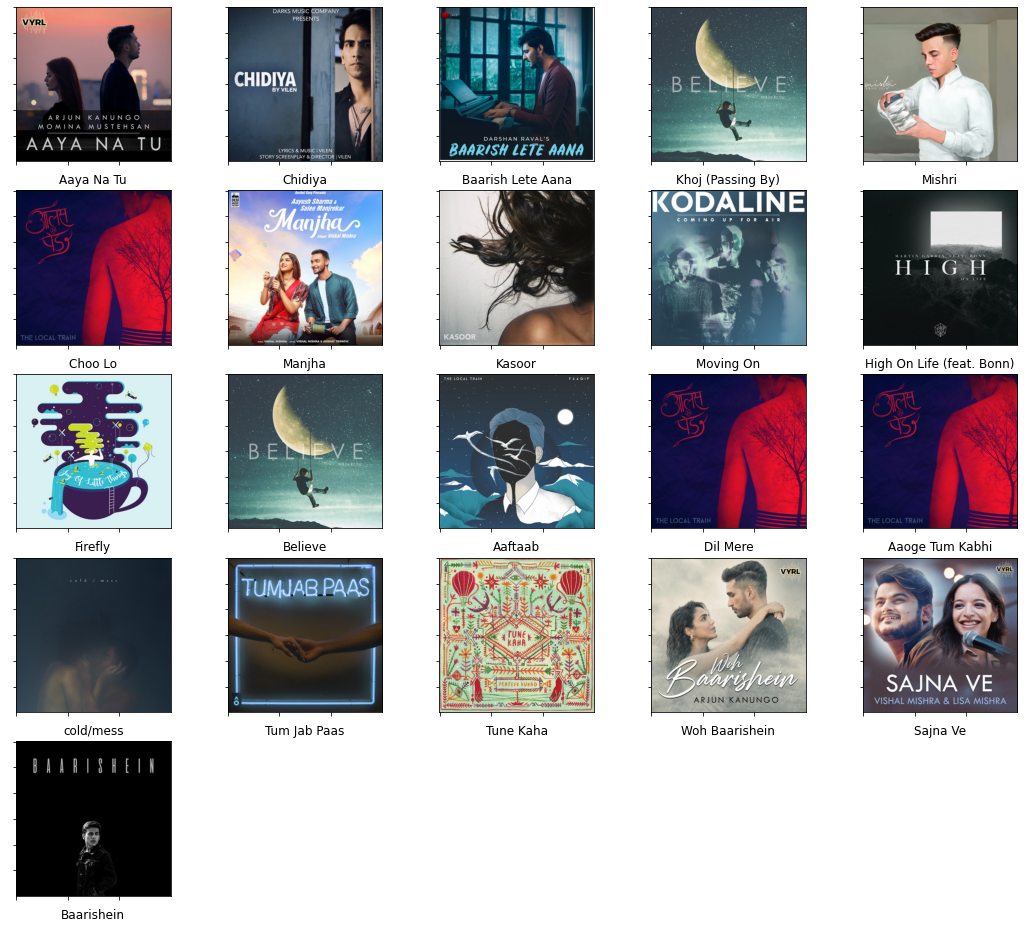

In [72]:
visualize_songs(playlist_Indie)

## Create Playlist Vector

In [73]:
def generate_playlist_feature(complete_feature_set, playlist_df, weight_factor):
    """ 
    Summarize a user's playlist into a single vector

    Parameters: 
        complete_feature_set (pandas dataframe): Dataframe which includes all of the features for the spotify songs
        playlist_df (pandas dataframe): playlist dataframe
        weight_factor (float): float value that represents the recency bias. The larger the recency bias, the most priority recent songs get. Value should be close to 1. 
        
    Returns: 
        playlist_feature_set_weighted_final (pandas series): single feature that summarizes the playlist
        complete_feature_set_nonplaylist (pandas dataframe): 
    """
    
    complete_feature_set_playlist = complete_feature_set[complete_feature_set['song_id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1).mean(axis =0)
    complete_feature_set_playlist = complete_feature_set_playlist.merge(playlist_df[['id','date_added']],  left_on='song_id', right_on='id', how = 'inner')
    complete_feature_set_nonplaylist = complete_feature_set[~complete_feature_set['song_id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1)
    
    playlist_feature_set = complete_feature_set_playlist.sort_values('date_added',ascending=False)

    most_recent_date = playlist_feature_set.iloc[0,-1]
    
    for ix, row in playlist_feature_set.iterrows():
        playlist_feature_set.loc[ix,'months_from_recent'] = int((most_recent_date.to_pydatetime() - row.iloc[-1].to_pydatetime()).days / 30)
        
    playlist_feature_set['weight'] = playlist_feature_set['months_from_recent'].apply(lambda x: weight_factor ** (-x))
    
    playlist_feature_set_weighted = playlist_feature_set.copy()
    #print(playlist_feature_set_weighted.iloc[:,:-4].columns)
    playlist_feature_set_weighted.update(playlist_feature_set_weighted.iloc[:,:-5].mul(playlist_feature_set_weighted.weight,0))
    playlist_feature_set_weighted_final = playlist_feature_set_weighted.iloc[:, :-5]
    #playlist_feature_set_weighted_final['id'] = playlist_feature_set['id']
    
    return playlist_feature_set_weighted_final.sum(axis = 0), complete_feature_set_nonplaylist

In [74]:
complete_feature_set_playlist_vector_Indie, complete_feature_set_nonplaylist_Indie = generate_playlist_feature(complete_feature_set, playlist_Indie, 1.09)


In [75]:
complete_feature_set_playlist_vector_Indie.shape


(4899,)

## Generate Recommendations

In [78]:
def generate_playlist_recos(df, features, nonplaylist_features, batch_size=10000):
    """ 
    Generate song recommendations using incremental processing.

    Parameters: 
        df (pandas dataframe): Spotify DataFrame
        features (pandas series): Summarized playlist feature vector
        nonplaylist_features (pandas dataframe): Feature set of songs not in the playlist
        batch_size (int): Number of rows to process in each batch
        
    Returns: 
        non_playlist_df_top_40: Top 40 recommendations for the playlist
    """
    # Filter non-playlist songs in the main DataFrame
    non_playlist_df = df[df['song_id'].isin(nonplaylist_features['song_id'].values)]
    
    # Prepare a list to store similarity scores
    similarities = []

    # Convert the target feature vector to a 2D array
    target_features = features.values.reshape(1, -1)
    
    # Process non-playlist features in batches
    num_rows = nonplaylist_features.shape[0]
    
    for start in range(0, num_rows, batch_size):
        end = min(start + batch_size, num_rows)
        
        # Get the current batch
        batch_features = nonplaylist_features.iloc[start:end].drop('song_id', axis=1).values
        
        # Calculate cosine similarity for the batch
        batch_sim = cosine_similarity(batch_features, target_features)[:, 0]
        
        # Append the batch similarity to the list
        similarities.extend(batch_sim)
    
    # Add the similarity scores to the DataFrame
    non_playlist_df['sim'] = similarities

    # Sort songs by similarity and get top 40 recommendations
    non_playlist_df_top_40 = non_playlist_df.sort_values('sim', ascending=False).head(40)
    
    # Fetch the cover art for the top 40 recommended songs
    non_playlist_df_top_40['url'] = non_playlist_df_top_40['song_id'].apply(
    lambda x: sp.track(x)['album']['images'][1]['url'] 
    if len(sp.track(x)['album']['images']) > 1 
    else (sp.track(x)['album']['images'][0]['url'] 
          if len(sp.track(x)['album']['images']) > 0 
          else 'https://via.placeholder.com/150'))  # Placeholder URL if no images are available

    return non_playlist_df_top_40


In [79]:
indie_top40 = generate_playlist_recos(spotify_df_upd, complete_feature_set_playlist_vector_Indie, complete_feature_set_nonplaylist_Indie, batch_size=10000)


In [80]:
indie_top40

song_id                               song_name  \
155061  6l1VsKiMyaUWElFrM1rsuu                                Saansein   
155067  6q7bXTv3yBedHblKRoC5uu                                   Kadam   
308196  6nZiYSBwPQ7fYnVWkkkj4g                      Kho Gaye Hum Kahan   
496664  4BL4aEbddW0OGv6fFYYFUt                                   Ocean   
155066  4sO9tnvCH3DJZ3AAXoixjd                           Kahaan Ho Tum   
155064  02sas1xqIwRm7iWSoHDvKe                                 Oh Love   
68344   3Gc4zbfvgZSBEfpd0aWEFb                                   Khudi   
402391  1lIYP8fDGGnp91OMTUnwjV                         Waqt Ki Baatein   
496668  74kCarkFBzXYXNkkYJIsG0                            Alag Aasmaan   
504920  3e44jPHjpH8gGWWD6Ey4ih          Iktara - MTV Unplugged Version   
500401  4kXkT9HF9ZfDjuv3LIKcwJ  Dil Beparvah - The Dewarists, Season 5   
308191  6rxTqUH90IfxJBc1dNgpLB  Sang Rahiyo (feat. Ranveer Allahbadia)   
496666  5qyEyqpT0TBVun8W07MEmR                                   Maula   
308194  6GT0oiQdjiYX91qgAMi7Vd                                 Nit Nit   
496663  6Ln89sczgIcAJXGAIdS94R                                    Riha   
68343   6IskNuvBwK8YzFrjvXIp5h                         Yeh Zindagi Hai   
68345   1H5TcdTdMYvOfJ31SAA6H5                            Kaisey Jiyun   
155069  3FrrdMIPRwHTu5DEBtVhjL                             Ab Hoga Kya   
68348   2sNMcxZh7AwImXtrv8UV3S                                  Bandey   
155062  4gmiZNpLPThX70sR1Ro5eV                             Rubber Bits   
155070  5RjOdVrGkXEo1hEaAlHgq4                       A Shot of Alcohol   
155068  6pyo8b4z73BdxrOX3rvMvK                       Chahe Ya Na Chahe   
155056  51Gk1czQl7NjX0jHwawO1G                                 Yeh Pal   
155057  0tnMpHtgVUrSfMOrtIhhmy                                     Voh   
155060  2jlPMNMojBNtGZTnSuXItA                         Something Wrong   
155063  4LK7Zr5pHt6vGr54Ut38su                              Raat Raazi   
308197  3Frn3MJRQFvjCIbTbBUZCS                         Jahaan Tu Chala   
235670  6w458kA8WOAIZr1ublxnK9                               Safarnama   
308195  4c8erEn1DjLoDp0CRLkNnq                         Nachde Ne Saare   
308198  20rwogC6aE369YsxFb5aRp                           Din Shagna Da   
153894  3MzNYNwL7I4dhG4sa1VkK1                         Dil Dhadakne Do   
141391  1eZ9Kq8voa1bnJi3dZD8M1                 Judaai (From "Badlapur)   
190641  4pE05HNzmVFGpCOfNKE3w6      Tum Hi Ho Bandhu (From "Cocktail")   
504922  1U5ZT7c7Sw84xDcoEt0Zaq                                  Iktara   
504911  6k3XXCE1ZzwevQlxf8dNaw                        Love You Zindagi   
308192  4mYrbFGkk5u3bnDhTj0jAO                                 Raatein   
186757  7vPyfglQrBBQ0MmQ0V7d7I                         Bas Main Aur Tu   
504921  0qxTDueomxqHEUPwlD9y4S             Iktara (From "Wake Up Sid")   
308193  5Br8K1CLLVB7AuuM0t4G7r                                   Preet   
186756  78vh1SHHtT8MUZ2MUft4xG                     You're So Beautiful   

        popularity  duration_ms  explicit  \
155061          57       266042         0   
155067          52       214604         0   
308196          69       213056         0   
496664          51       252630         0   
155066          56       155289         0   
155064          50       211193         0   
68344           52       297643         0   
402391          61       243310         0   
496668          61       212773         0   
504920          41       553591         0   
500401          56       250000         0   
308191          60       213288         0   
496666          54       237882         0   
308194          59       246136         0   
496663          59       287324         0   
68343           44       249160         0   
68345           45       239085         0   
155069          39       254302         0   
68348           45       305336         0   
155062          34       237867         0   
155070          35       168587         0  

In [82]:
def visualize_recommended_songs(df):
    """ 
    Visualize cover art of the songs in the inputted dataframe

    Parameters: 
        df (pandas dataframe): Playlist Dataframe
    """
    
    temp = df['url'].values
    plt.figure(figsize=(15,int(0.625 * len(temp))))
    columns = 5
    
    # Calculate the number of rows and round up
    num_rows = math.ceil(len(temp) / columns)
    
    for i, url in enumerate(temp):
        plt.subplot(num_rows, columns, i + 1)

        image = io.imread(url)
        plt.imshow(image)
        plt.xticks(color = 'w', fontsize = 0.1)
        plt.yticks(color = 'w', fontsize = 0.1)
        plt.xlabel(df['song_name'].values[i], fontsize = 12)
        plt.tight_layout(h_pad=0.4, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)

    plt.show()

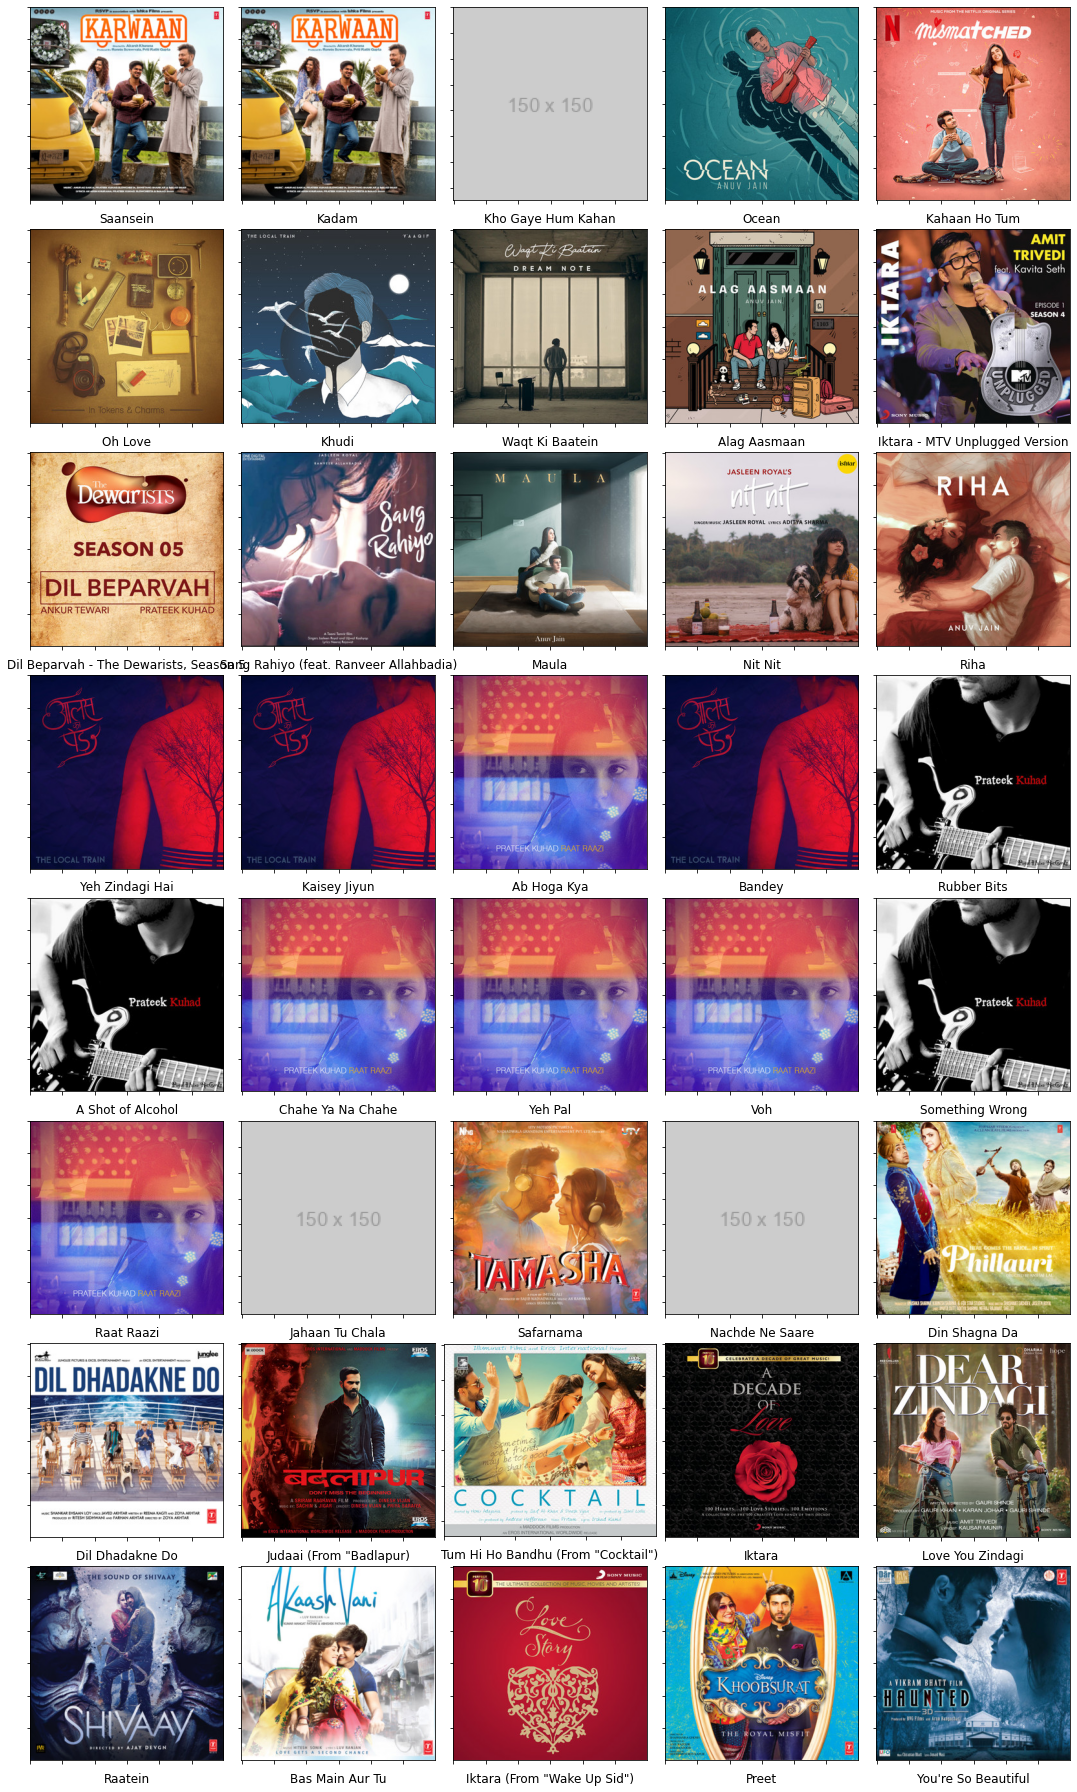

In [83]:
visualize_recommended_songs(indie_top40)
